In [1]:
setwd('/import/DB/fel/BJTC-204')

In [2]:
exp<- read.table("./00_rawdata/exp.txt",sep = '\t',header = T,row.names = 1) 

In [3]:
length(unique(colnames(exp)))

[1] 161

In [144]:
#model.gene = rownames(exp)[1:50]

In [5]:
model.gene = c('RPE65' ,'DRD3', 'MC3R','RELB',  'PRF1')

In [6]:
data = as.data.frame(t(exp[model.gene,]))

In [7]:
library(readxl)

Warning message:
"package 'readxl' was built under R version 4.2.3"


In [10]:
length(unique(group$Symbol))

[1] 161

In [11]:
group = read_excel("./00_rawdata/DLPFC_group.xlsx")

In [12]:
library(dplyr)

Warning message:
"package 'dplyr' was built under R version 4.2.3"

Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union




In [13]:
expr = data %>% as.data.frame() %>% 
tibble::rownames_to_column(.,'sample')

In [14]:
expr3 = merge(group,expr,by.x = 'Symbol',by.y = 'sample')

In [15]:
expr3[expr3$Group =='MDD',]$Group<-1
expr3[expr3$Group =='control',]$Group<-0
expr3$Group = as.numeric(expr3$Group)

In [16]:
expr3 = expr3[,-1]

In [17]:
fit.reduce<-glm(Group~RPE65 + DRD3+ MC3R+RELB  + PRF1 ,data=expr3,family=binomial())
summary(fit.reduce)


Call:
glm(formula = Group ~ RPE65 + DRD3 + MC3R + RELB + PRF1, family = binomial(), 
    data = expr3)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.1009  -1.2207   0.6785   0.8175   1.2622  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)
(Intercept)  13.5174     9.4573   1.429    0.153
RPE65         2.6519     2.2095   1.200    0.230
DRD3         -3.1866     2.3896  -1.334    0.182
MC3R         -1.2185     1.6441  -0.741    0.459
RELB         -0.6897     0.9532  -0.724    0.469
PRF1          0.1467     1.2799   0.115    0.909

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 186.87  on 160  degrees of freedom
Residual deviance: 179.68  on 155  degrees of freedom
AIC: 191.68

Number of Fisher Scoring iterations: 4


Waiting for profiling to be done...



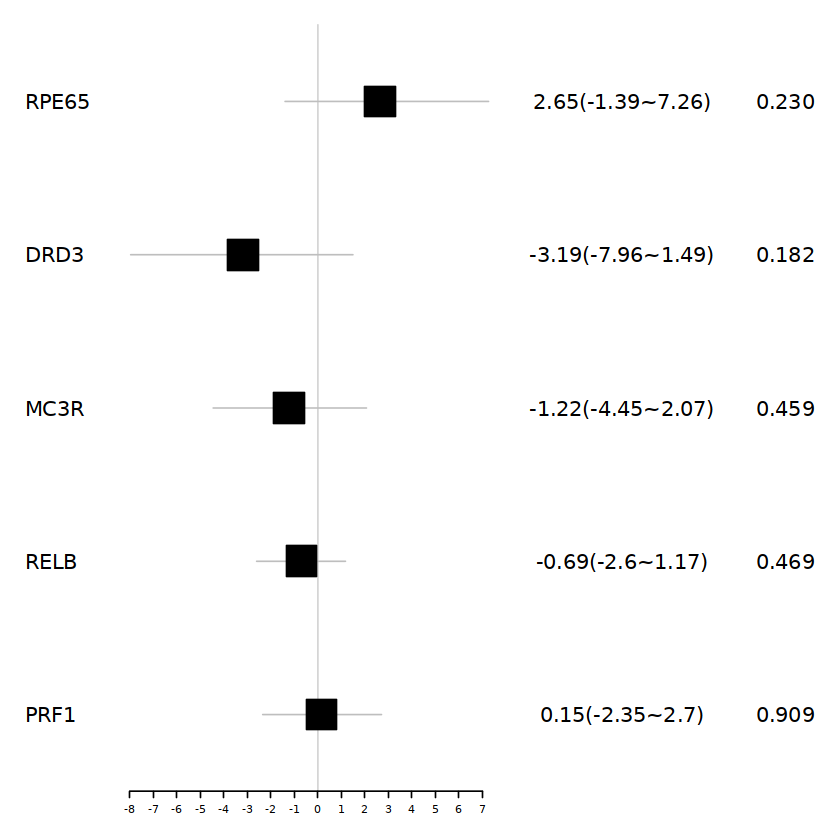

In [178]:
fit.result<-summary(fit.reduce)
df1<-fit.result$coefficients
df2<-confint(fit.reduce)
df3<-cbind(df1,df2)
df4<-data.frame(df3[-1,c(1,4,5,6)])
df4$Var<-rownames(df4)
colnames(df4)<-c("OR","Pvalue","OR_1","OR_2","Var")
df5<-df4[,c(5,1,2,3,4)]
df5$OR_mean<-df5$OR
df5$OR<-paste0(round(df5$OR,2),
               "(",
               round(df5$OR_1,2),
               "~",
               round(df5$OR_2,2),
               ")")
df5$Pvalue<-round(df5$Pvalue,3)
write.csv(df5,file = "forestplot_example2.csv",
          quote = F,row.names = F)

library(forestplot)
fp<-read.csv("forestplot_example2.csv",header=T)

forestplot(labeltext=as.matrix(fp[,1:3]),
           mean=fp$OR_mean,
           lower=fp$OR_1,
           upper=fp$OR_2,
           zero=0,
           boxsize=0.2,
           graph.pos=2)

In [18]:
summary(fit.reduce) #查看构建的模型
fitted.prob<-predict(fit.reduce, newdata = expr3, type = "response")  #这里不需要变动
expr3$pred<-fit.reduce$fitted.values
m<-pROC::roc(expr3$Group,expr3[,"pred"])  #这里要把Y改为自己的结局变量即可


Call:
glm(formula = Group ~ RPE65 + DRD3 + MC3R + RELB + PRF1, family = binomial(), 
    data = expr3)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.1009  -1.2207   0.6785   0.8175   1.2622  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)
(Intercept)  13.5174     9.4573   1.429    0.153
RPE65         2.6519     2.2095   1.200    0.230
DRD3         -3.1866     2.3896  -1.334    0.182
MC3R         -1.2185     1.6441  -0.741    0.459
RELB         -0.6897     0.9532  -0.724    0.469
PRF1          0.1467     1.2799   0.115    0.909

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 186.87  on 160  degrees of freedom
Residual deviance: 179.68  on 155  degrees of freedom
AIC: 191.68

Number of Fisher Scoring iterations: 4


Setting levels: control = 0, case = 1

Setting direction: controls < cases



In [19]:
library(ggplot2)

Warning message:
"package 'ggplot2' was built under R version 4.2.3"


Area under the curve: 0.6315

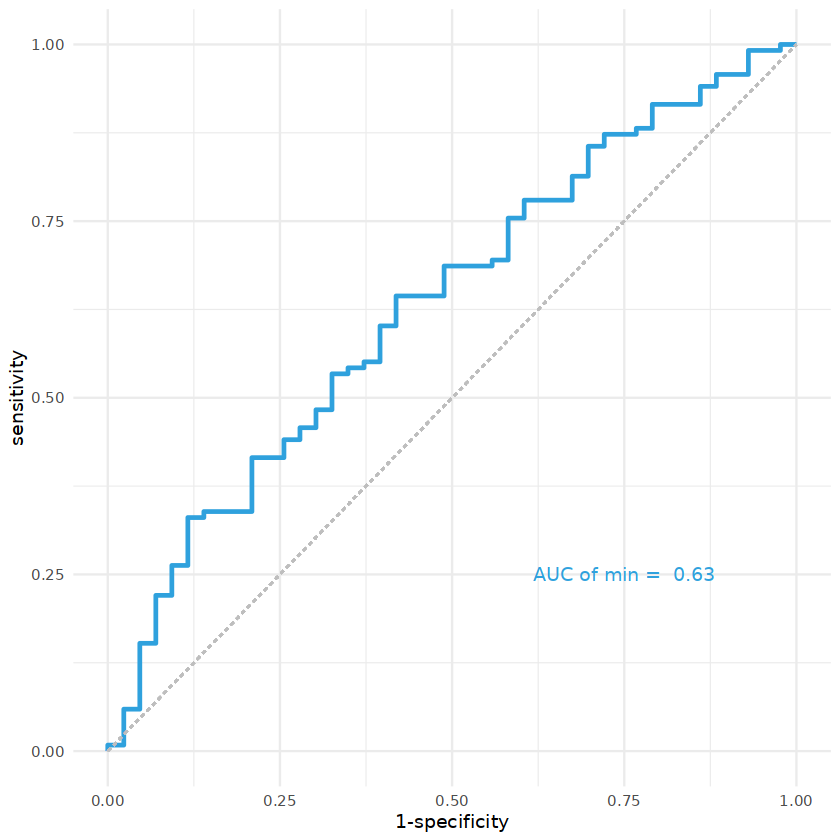

In [20]:
g <- pROC::ggroc(m,legacy.axes = T,size = 1,color = "#2fa1dd")
pROC::auc(m)  # Area under the curve: 0.9953

g + theme_minimal() +
  geom_segment(aes(x = 0, xend = 1, y = 0, yend = 1), 
               colour = "grey", linetype = "dashed")+
  annotate("text",x = .75, y = .25,
           label = paste("AUC of min = ",format(round(as.numeric(pROC::auc(m)),2),nsmall = 2)),color = "#2fa1dd")

In [21]:
library(ROCR)
library(rms)

Warning message:
"package 'ROCR' was built under R version 4.2.3"
Loading required package: Hmisc

Warning message:
"package 'Hmisc' was built under R version 4.2.3"

Attaching package: 'Hmisc'


The following objects are masked from 'package:dplyr':

    src, summarize


The following objects are masked from 'package:base':

    format.pval, units




In [22]:
expr3$Group = as.factor(expr3$Group)

In [23]:
dd<-rms::datadist(expr3)  #开始打包数据
options(datadist="dd")

In [24]:
formula1<-as.formula(Group~. )  #RPE65 + MC3R+NFIL3 + PRF1 + IL6
fit1<-lrm(formula1,data = expr3,x=T,y=T)

In [25]:
# nom1 <- rms::nomogram(fit1, fun=plogis,
#                 #fun.at=c(0.001,0.1,0.25,0.5,0.75,0.9,0.99),
#                  #lp=T, # 是否显示线性概率
#                  funlabel="Risk of Death")  
# plot(nom1) 


In [39]:
mdd = group %>% dplyr::filter(Group == 'MDD') 

In [42]:
mdd.sample = mdd$Symbol

In [58]:
nmfinput = expr %>% dplyr::filter(sample %in%  mdd.sample)

In [59]:
dim(nmfinput)

[1] 118   6

In [60]:
length(unique(nmfinput$sample))

[1] 118

In [61]:
rownames(nmfinput) = nmfinput[,1]
nmfinput = as.data.frame(t(nmfinput[,-c(1)]))

In [63]:
library(NMF)

Loading required package: registry

Warning message:
"package 'registry' was built under R version 4.2.3"
Loading required package: rngtools

Warning message:
"package 'rngtools' was built under R version 4.2.3"
Loading required package: cluster

Warning message:
"package 'cluster' was built under R version 4.2.3"
NMF - BioConductor layer [OK] | Shared memory capabilities [NO: bigmemory] | Cores 2/2

  To enable shared memory capabilities, try: install.extras('
NMF
')



In [85]:
ranks <- 1:10
estim.coad <- nmf(nmfinput,ranks, nrun=10)
duplicated(colnames(nmfinput))

Warning message in cor(d.consensus, d.coph, method = "pearson"):
"the standard deviation is zero"


[1] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [13] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [25] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [37] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [49] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [61] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [73] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [85] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [97] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
[109] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE

Warning message:
"Removed 4 rows containing missing values (`geom_line()`)."
Warning message:
"Removed 6 rows containing missing values (`geom_point()`)."


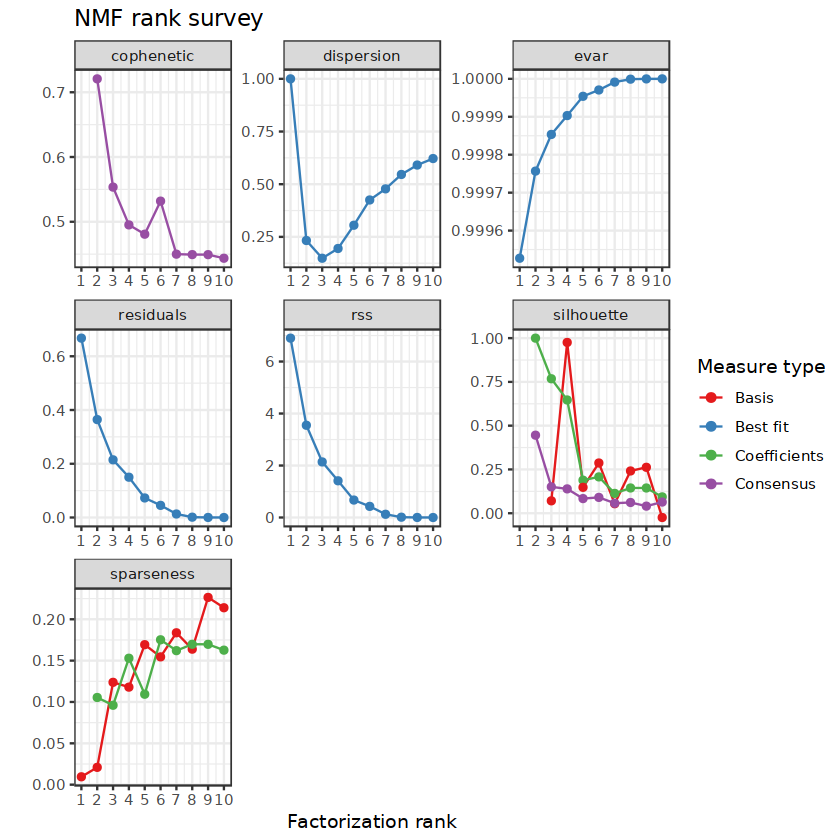

In [86]:
plot(estim.coad)

In [87]:
seed = 2020820
nmf.rank4 <- nmf(nmfinput, 
                 rank = 2, 
                 nrun=50,
                 seed = seed, 
                 method = "brunet")

group
 1  2 
48 70 

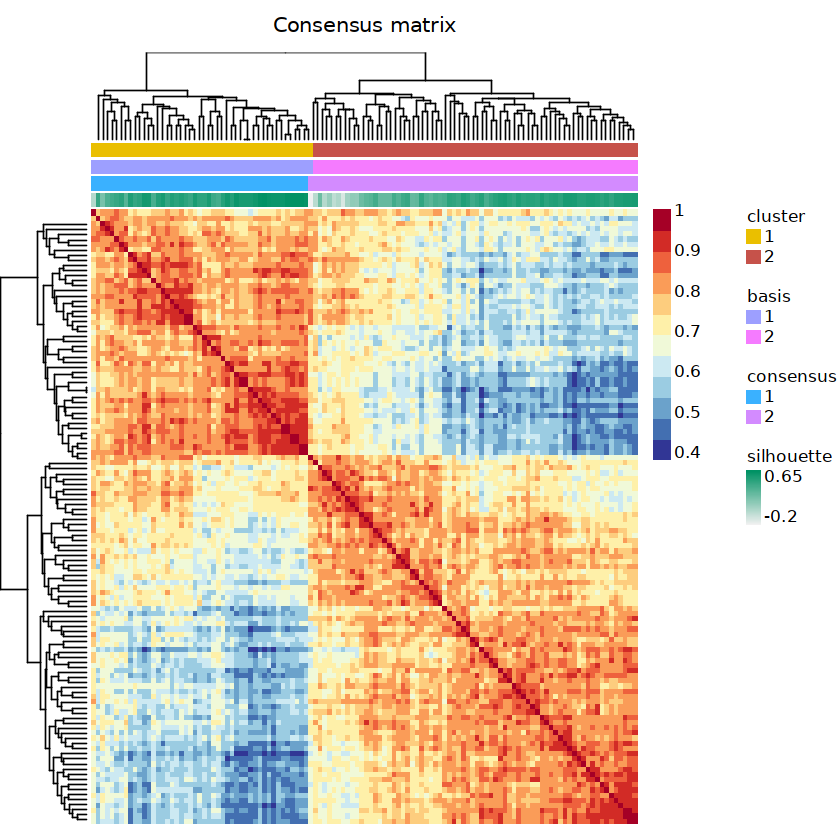

In [91]:
jco <- c("#EABF00","#C6524A","#868686")
index <- extractFeatures(nmf.rank4,"max") 
sig.order <- unlist(index)
NMF.Exp.rank4 <- nmfinput[sig.order,]
NMF.Exp.rank4 <- na.omit(NMF.Exp.rank4) #sig.order有时候会有缺失值
group <- predict(nmf.rank4) # 提出亚型
table(group)
consensusmap(nmf.rank4,
             labRow = NA,
             labCol = NA,
             annCol = data.frame("cluster"=group[colnames(NMF.Exp.rank4)]),
             annColors = list(cluster=c("1"=jco[1],"2"=jco[2])))

In [92]:
library(tinyarray)

In [101]:
dim(nmfinput)

[1]   5 118

[1] "GSM1124359" "GSM1124360" "GSM1124361" "GSM1124362" "GSM1124363"
  [6] "GSM1124364" "GSM1124366" "GSM1124367" "GSM1124369" "GSM1124370"
 [11] "GSM1124371" "GSM1124372" "GSM1124373" "GSM1124374" "GSM1124378"
 [16] "GSM1124380" "GSM1124381" "GSM1124383" "GSM1124384" "GSM1124386"
 [21] "GSM1124388" "GSM1124389" "GSM1124392" "GSM1124395" "GSM1124398"
 [26] "GSM1124399" "GSM1124400" "GSM1124401" "GSM1124402" "GSM1124404"
 [31] "GSM1124405" "GSM1124406" "GSM1124407" "GSM1124408" "GSM1124410"
 [36] "GSM1124411" "GSM1124412" "GSM1124413" "GSM1124414" "GSM1124415"
 [41] "GSM1124417" "GSM1124418" "GSM1124419" "GSM1124421" "GSM1124422"
 [46] "GSM1124424" "GSM1124426" "GSM1124427" "GSM1124428" "GSM1124429"
 [51] "GSM1124430" "GSM1124431" "GSM1124432" "GSM1124433" "GSM1124434"
 [56] "GSM1124435" "GSM1124436" "GSM1124437" "GSM1124438" "GSM1124439"
 [61] "GSM1124440" "GSM1124442" "GSM1124443" "GSM1124444" "GSM1124446"
 [66] "GSM1124447" "GSM1124449" "GSM1124452" "GSM1124453" "GSM1124454"
 [71] "GSM1124455" "GSM1124456" "GSM1124457" "GSM1124458" "GSM1124459"
 [76] "GSM1124460" "GSM1124463" "GSM1124464" "GSM1124465" "GSM1124466"
 [81] "GSM1124467" "GSM1124469" "GSM1124470" "GSM1124471" "GSM1124472"
 [86] "GSM1124473" "GSM1124475" "GSM1124476" "GSM1124481" "GSM1124484"
 [91] "GSM1124485" "GSM1124486" "GSM1124487" "GSM1124488" "GSM1124489"
 [96] "GSM1124491" "GSM1124492" "GSM1124493" "GSM1124494" "GSM1124495"
[101] "GSM1124497" "GSM1124498" "GSM1124499" "GSM1124500" "GSM1124501"
[106] "GSM1124502" "GSM1124504" "GSM1124505" "GSM1124506" "GSM1124507"
[111] "GSM1124508" "GSM1124509" "GSM1124510" "GSM1124511" "GSM1124512"
[116] "GSM1124514" "GSM1124515" "GSM1124517"

In [145]:
a = exp[,colnames(nmfinput)]

In [171]:
cg=names(tail(sort(apply(a,1,sd)),12000))
n=a[cg,]

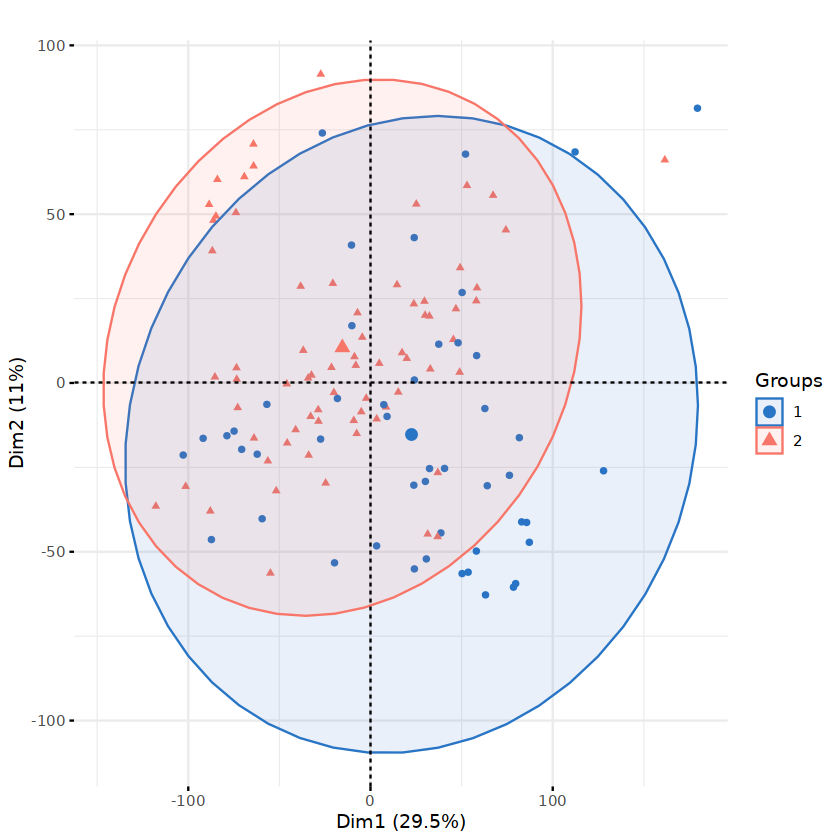

In [172]:
draw_pca(n,group)

In [173]:
library(Rtsne)
tsne_out = Rtsne(t(n),perplexity = 30)
pdat = data.frame(tsne_out$Y,factor(group))
colnames(pdat) = c("Y1","Y2","group")
head(pdat)

,Y1,Y2,group
,<dbl>,<dbl>,<fct>
GSM1124359,2.989048,0.12497465,2
GSM1124360,3.019081,0.90920310,2
GSM1124361,2.684348,-0.57165651,2
GSM1124362,2.926217,0.06835012,2
GSM1124363,2.001950,-6.50784714,2
GSM1124364,3.554302,-1.72105343,2


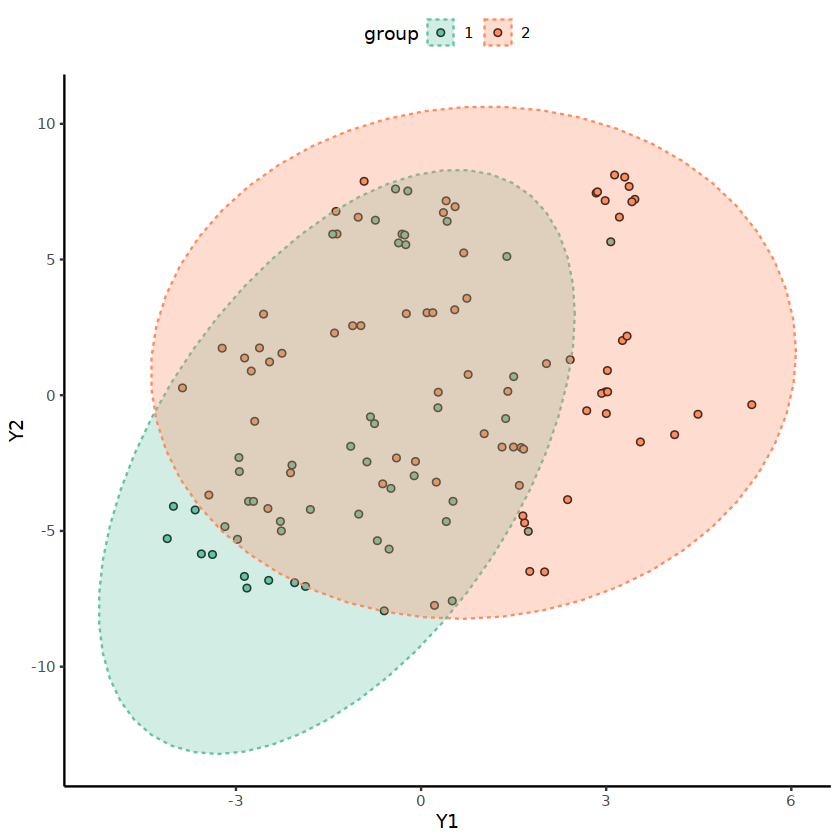

In [174]:
library(ggplot2)
library(paletteer)
ggplot(pdat,aes(Y1,Y2))+
  geom_point(aes(Y1,Y2,fill = group),shape = 21,color = "black")+
  stat_ellipse(aes(color = group,fill = group),
               geom = "polygon",
               alpha = 0.3,
               linetype = 2)+
  scale_color_paletteer_d("RColorBrewer::Set2")+
  scale_fill_paletteer_d("RColorBrewer::Set2")+
  theme_classic()+
  theme(legend.position = "top")

In [162]:
groupinfo = as.data.frame(group)

In [125]:
save(nmfinput,groupinfo,file = 'bulk2.rda')